In [2]:
# connect to console with: jupyter console --existing kernel-xxx.json
%connect_info

{"key":"4b92e3a8-d96e-4598-a6b1-efb0dae9e4bf","signature_scheme":"hmac-sha256","transport":"tcp","ip":"127.0.0.1","hb_port":9000,"control_port":9001,"shell_port":9002,"stdin_port":9003,"iopub_port":9004,"kernel_name":"python3810jvsc74a57bd0916dbcbb3f70747c44a77c7bcd40155683ae19c65e1c03b4aa3499c5328201f1"}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-v2-3413swXViCf6ubn.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [3]:
from sympy import *
from sympy.physics.mechanics import *
from IPython.display import display, Math
init_vprinting()

OK, Condizioni critiche
m_dot = 0.05452336108469578


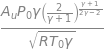

In [4]:
## Symbolic ##
# from slides 12.., 32.. of UGELLI
# m_dot = rho v A # valid in each point of a conduct
# Procedura:
# 	- verifica condizioni critiche
#	- Ipotesi condizioni critiche: A = A*, psi = psi*, eta = eta*
# 	- calcolo portata
#	- dinamica dello sparo
# 	- dinamica del volo
# Identificazione:
# 	- massa cubo piccolo 66g
# 	- massa cubo grande 231g

# define variables
P_0, T_0, P_u, A_u, gamma, R, C_d = symbols('P_0 T_0 P_u A_u gamma R C_d', real=True)
var_symb = [P_0, T_0, P_u, A_u, gamma, R, C_d]
# A_u was 22e-6, A_ventosa: 7mm -> pi*0.0035^2 = 3.84845e-5
var = {P_0: 6e5, T_0: 293.0, P_u: 1e5, A_u: 3.84845e-5, gamma: 1.4, R: 287.0, C_d: 1.0}

# Verifica condizioni critiche (in condizioni non critiche si deve calcolare M)
# slide 16 UGELLI
eta = P_u/P_0
eta_s = (2/(gamma+1))**(gamma/(gamma-1))
# numeric
eta_ = eta.subs(var).evalf()
eta_s_ = eta_s.subs(var).evalf()

if eta_ < eta_s_:
    print('OK, Condizioni critiche')

# In condizioni critiche la portata massica dipende linearmente da P_0
# Dipende anche da A_u, che sarà un parametro da identificare
# da capire che ruolo ha A*(minore sezione condotto?), considero A_u = A*
a0 = sqrt(gamma*R*T_0)
psi_s = gamma * (2/(gamma+1))**((gamma+1)/(2*(gamma-1)))
m_dot = P_0 * A_u * psi_s / a0

# create function (uses * for unpack and dict.values() to return the list)
get_m_dot = lambdify(var_symb, m_dot, 'numpy')
m_dot_ = get_m_dot(*list(var.values()))

print('m_dot = {}'.format(m_dot_))

m_dot 

F_obj = 9.353871527777777


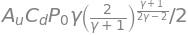

In [5]:
# dinamica dello sparo
# in condizion critiche la velocità è a0 nella gola, considero uguale quella di uscita
v_u = a0

# forza agente sul tool
F_tool = m_dot * v_u

# forza agente sull'oggetto, la forza di drag è: F_d = 1/2*rho_*v_u^2*A*C_d
# since m_dot = rho v A
F_obj = F_tool * C_d / 2

# create function (uses * for unpack and dict.values() to return the list)
get_F_obj = lambdify(var_symb, F_obj, 'numpy')
F_obj_ = get_F_obj(*list(var.values()))

print('F_obj = {}'.format(F_obj_))

F_obj

In [6]:
m_obj, dT = symbols('m_obj dT', real=True)
new_var = [m_obj, dT]
for item in new_var:
    if item not in var_symb:
        var_symb.append(item)
var[m_obj] = 0.231 # 0.109
var[dT] = 0.145 # 0.055

# velocità finale oggetto se sparo sul centro di massa
a = F_obj / m_obj
v_obj = a * dT

# create function
get_v_obj = lambdify(var_symb, v_obj, 'numpy')
v_obj_ = get_v_obj(*list(var.values()))

print('v_obj = {}'.format(v_obj_))

v_obj = 5.871477798821548


In [7]:
# projectile motion
#d = \frac{v \cos(\theta)}{g}\Big(v \sin(\theta) + \sqrt{v^2\sin^2(\theta)+2gh}\Big)
theta, g, h = symbols('theta, g, h')
new_var = [theta, g, h]
for item in new_var:
    if item not in var_symb:
        var_symb.append(item)
var[theta] = 90 * 3.1415 / 180.0
var[g] = 9.81
var[h] = 0.5

distance = v_obj*cos(theta)/g * ( v_obj * sin(theta) + sqrt(v_obj**2 * sin(theta)**2 + 2*g*h))
v_z = v_obj*sin(theta)
t_height = v_z / g
# height = v_z*t_height - 1/2*g*t_height**2
height = 1/2*v_z**2 / g
energy = m_obj * g * height

# create functions
get_distance = lambdify(var_symb, distance, 'numpy')
get_height = lambdify(var_symb, height, 'numpy')
get_energy = lambdify(var_symb, energy, 'numpy')


In [8]:
# - test - #
distance_ = get_distance(*list(var.values()))
height_ = get_height(*list(var.values()))
energy_ = get_energy(*list(var.values()))

print('distance = {}'.format(distance_))
print('height = {}'.format(height_))
print('energy = {}'.format(energy_))

distance = 0.0003473179335134438
height = 1.7570974244682296
energy = 3.9817760445617005


In [9]:
# ----- IDENTIFICATION ----- #
# 	- mass little cube 66g
# 	- mass big cube 231g
import yaml
import matplotlib.pyplot as plt
import numpy as np

with open('throws.yaml', 'r') as file:
    throws = yaml.safe_load(file)

valve_ms1_cubeLittle = throws['throws_cubeLittle_51_52_test01']['valve_ms']
height1_cubeLittle = throws['throws_cubeLittle_51_52_test01']['height']
valve_ms2_cubeLittle = throws['throws_cubeLittle_51_52_test04']['valve_ms']
height2_cubeLittle = throws['throws_cubeLittle_51_52_test04']['height']
valve_ms3_cubeLittle = throws['throws_cubeLittle_52_53_test01']['valve_ms']
height3_cubeLittle = throws['throws_cubeLittle_52_53_test01']['height']

# valve_ms_cubeLittle = [valve_ms1_cubeLittle, valve_ms2_cubeLittle, valve_ms3_cubeLittle]
# height_cubeLittle = [height1_cubeLittle, height2_cubeLittle, height3_cubeLittle]

valve_ms1_cubeBig = throws['throws_cubeBig_53_54_test01']['valve_ms']
height1_cubeBig = throws['throws_cubeBig_53_54_test01']['height']
valve_ms2_cubeBig = throws['throws_cubeBig_55_145_test01']['valve_ms']
height2_cubeBig = throws['throws_cubeBig_55_145_test01']['height']

# - energy - #
# energy1_cubeLittle = 0.066 * 9.81 * height1_cubeLittle
# energy2_cubeLittle = 0.066 * 9.81 * height2_cubeLittle
# energy3_cubeLittle = 0.066 * 9.81 * height3_cubeLittle
# energy1_cubeBig = 0.066 * 9.81 * height1_cubeBig
# energy2_cubeBig = 0.066 * 9.81 * height2_cubeBig
energy1_cubeLittle = [x*0.066*9.81 for x in height1_cubeLittle]
energy2_cubeLittle = [x*0.066*9.81 for x in height2_cubeLittle]
energy3_cubeLittle = [x*0.066*9.81 for x in height3_cubeLittle]
energy1_cubeBig = [x*0.231*9.81 for x in height1_cubeBig]
energy2_cubeBig = [x*0.231*9.81 for x in height2_cubeBig]

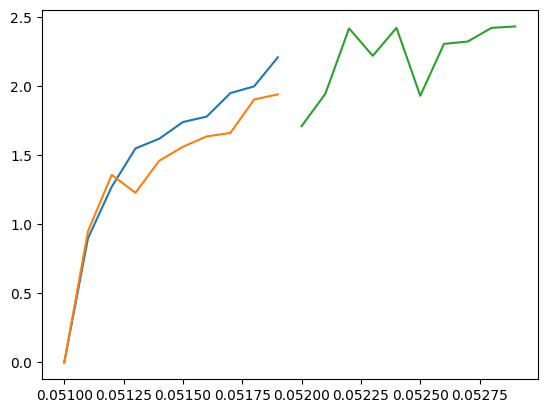

In [10]:
# cubeLittle tests
plt.plot(valve_ms1_cubeLittle, height1_cubeLittle)
plt.plot(valve_ms2_cubeLittle, height2_cubeLittle)
plt.plot(valve_ms3_cubeLittle, height3_cubeLittle)

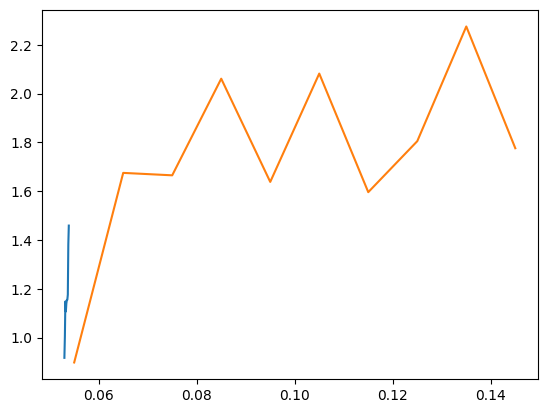

In [11]:
# cubeLittle tests
plt.plot(valve_ms1_cubeBig, height1_cubeBig)
plt.plot(valve_ms2_cubeBig, height2_cubeBig)

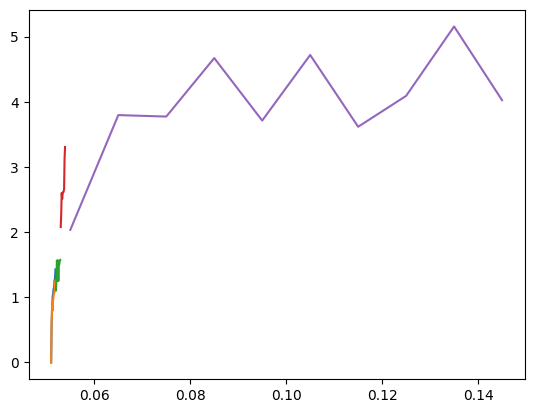

In [12]:
# - energy plots - #
# cubeLittle tests
plt.plot(valve_ms1_cubeLittle, energy1_cubeLittle)
plt.plot(valve_ms2_cubeLittle, energy2_cubeLittle)
plt.plot(valve_ms3_cubeLittle, energy3_cubeLittle)
plt.plot(valve_ms1_cubeBig, energy1_cubeBig)
plt.plot(valve_ms2_cubeBig, energy2_cubeBig)

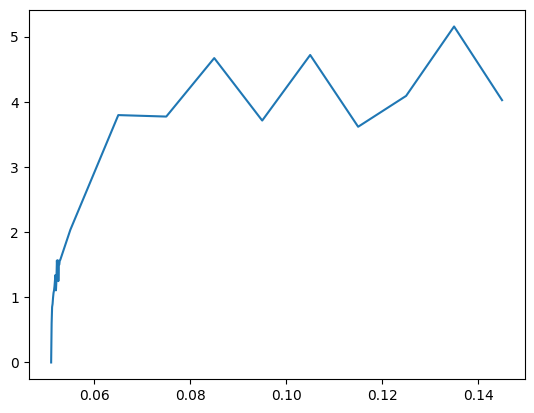

In [13]:
valve_ms = valve_ms1_cubeLittle + valve_ms3_cubeLittle + valve_ms2_cubeBig
energy1_mean = [(a+b)/2 for a,b in zip(energy1_cubeLittle, energy2_cubeLittle)]
energy = energy1_mean + energy3_cubeLittle + energy2_cubeBig
plt.plot(valve_ms, energy)

/tmp/ipykernel_28057/216346140.py:7: RuntimeWarning: invalid value encountered in power
  energy = a1 * (1 - a2**(a3*(t+a4)+a5))


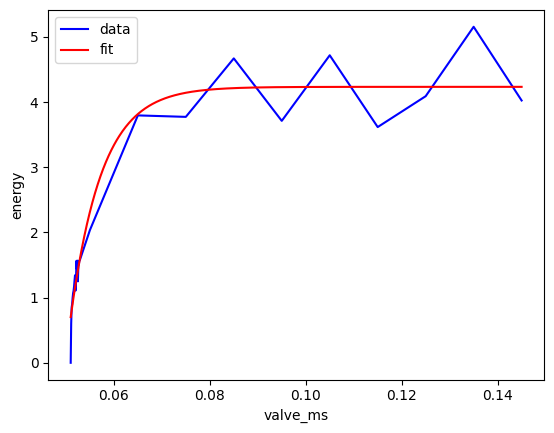

In [14]:
# --- function fitting --- #
from scipy.optimize import curve_fit

def fun_energy1(t, a1, a2, a3, a4, a5):
    # function to optimize where x and x1 are known
    # E, B0, S0 need to be fitted
    energy = a1 * (1 - a2**(a3*(t+a4)+a5))
    return energy

#define the data to be fit
xdata = np.array(valve_ms, dtype='float64')
ydata = np.array(energy, dtype='float64')
plt.plot(xdata, ydata, 'b-', label='data')

# fit for parameters with general function
popt, pcov = curve_fit(fun_energy1, xdata, ydata)
xdata_fit = np.linspace(xdata[0], xdata[-1], num=1000)
plt.plot(xdata_fit, fun_energy1(xdata_fit, *popt), 'r-', label='fit')

plt.xlabel('valve_ms')
plt.ylabel('energy')
plt.legend()
plt.show()


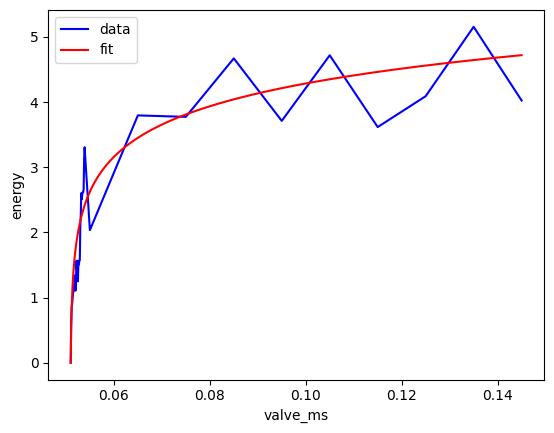

In [15]:
# fit parameters with log function
valve_ms = valve_ms1_cubeLittle + valve_ms3_cubeLittle + valve_ms1_cubeBig + valve_ms2_cubeBig
energy1_mean = [(a+b)/2 for a,b in zip(energy1_cubeLittle, energy2_cubeLittle)]
energy = energy1_mean + energy3_cubeLittle + energy1_cubeBig + energy2_cubeBig
xdata = np.array(valve_ms, dtype='float64')
ydata = np.array(energy, dtype='float64')

popt = np.polyfit(np.log(xdata), ydata, 1)
xdata_fit = np.linspace(xdata[0], xdata[-1], num=1000)
# energy_fit = [popt[0] * log(x-0.045) + popt[1] for x in xdata_fit]
# energy_fit = [1.0*log((x-0.0503)*1.5) + 6.85 for x in xdata_fit] # first fitted by hand
def fun_energy(x, x0):
    if x > x0:
        # - fitted on cubeLittle - #
        # a1 = 0.85
        # a2 = 1.0
        # a3 = -0.05097
        # b = 10
        # - fitted on all vector, best - #
        # a1 = 1.05
        # a2 = 1.0
        # a3 = -0.05092
        # b = 5
        # also Big1
        a1 = 2
        a2 = 1.0
        a3 = -0.05092
        b = 20
        y = a1*log(a2*x+a3, b) - a1*log(a2*x0+a3, b)
    else:
        y = 0
    return y

energy_fit = [fun_energy(x, xdata[0]) for x in xdata_fit] # fitted by hand on cubeLittle

plt.plot(xdata, ydata, 'b-', label='data')
plt.plot(xdata_fit, energy_fit, 'r-', label='fit')
plt.xlabel('valve_dt')
plt.ylabel('energy')
plt.legend()
plt.show()

In [16]:
# - returns the valve dt and the pose for the handtool to reach the target - #

def R_x(angle):
    R = np.array(((1, 0, 0), (0, cos(angle), -sin(angle)), (0, sin(angle), cos(angle))))
    return R

def R_y(angle):
    R = np.array(((cos(angle), 0, sin(angle)), (0, 1, 0), (-sin(angle), 0, cos(angle))))
    return R

def R_z(angle):
    R = np.array(((cos(angle), -sin(angle), 0), (sin(angle), cos(angle), 0), (0, 0, 1)))
    return R

def get_target_info(target):
    dist_base = 0.5 # plant distance from base
    h_base = 0.4	# tool height
    
    d_xy_target = target - np.array([0, 0, target[2]])
    pos_tool = d_xy_target/np.linalg.norm(d_xy_target)*dist_base
    pos_tool[2] = h_base
    
    dist = np.linalg.norm(d_xy_target) - dist_base
    
    h = target[2]-h_base
    
    return [dist, h, pos_tool]

def get_landing(m_obj, valve_dt, h, theta):
    valve_0 = 0.051
    g = 9.81
    v_obj = sqrt(2 * fun_energy(valve_dt, valve_0) / m_obj)
    distance = complex(v_obj*cos(theta)/g * ( v_obj * sin(theta) + sqrt(v_obj**2 * sin(theta)**2 + 2*g*h)))
    return distance.real
 


In [17]:
# --- optimization problem --- #
from scipy.optimize import minimize

def objective(x, par):
    _m_obj = par[0]
    target = par[1]
    [dist_desired, h, pos_tool]  = get_target_info(target)
    valve_dt = x[0]
    theta = x[1]
    dist = get_landing(_m_obj, valve_dt, h, theta)
    obj = (dist_desired-dist)**2
    return obj

# def constraint(x):
#     return x[0] - 0.051

def get_throwing_par(_m_obj, target):
    [target_dist, h, pos_tool] = get_target_info(target)
    # - solve optimization - #
    # - parameters - #
    par = (_m_obj, target) # tuple of parameters to pass
    # initial guesses
    x0 = np.zeros(2)
    x0[0] = 0.052
    x0[1] = 0
    
    # show initial objective
    print('Initial SSE Objective: ' + str(objective(x0, par)))
    
    # optimize
    b_valve = (0.051, 0.3)
    b_theta = (-3.1415/2, 3.1415/2)
    bnds = (b_valve, b_theta)
    # con1 = {'type': 'ineq', 'fun': constraint}
    # cons = ([con1])
    # solution = minimize(objective, x0, args=(par,), method='SLSQP', bounds=bnds, constraints=cons)
    solution = minimize(lambda x : objective(x, par), x0,  method='SLSQP', bounds=bnds)

    x = solution.x
    valve_dt = x[0]
    theta = x[1]
    # show final objective
    print('Final SSE Objective: ' + str(objective(x, par)))
    
    # print solution
    print('Solution')
    print('x1 = ' + str(x[0]))
    print('x2 = ' + str(x[1]))
    dist = get_landing(_m_obj, valve_dt, h, theta)
    print('distance: ' + str(dist))

    # get R from theta
    angle_z = atan2(target[1], target[0])
    angle_y = theta
    R = R_z(angle_z) * R_y(-pi-angle_y)
    
    return [valve_dt, pos_tool, R]

In [18]:
target = np.array([2.0, 0.0, 0.0])
m_obj = 0.2
[valve_dt, pos_tool, R] = get_throwing_par(m_obj, target)

Initial SSE Objective: 2.25
Final SSE Objective: 3.8693314551850206e-10
Solution
x1 = 0.05239469709905625
x2 = 0.9916943634812504
distance: 1.5000196706162974


In [19]:
# quanto l'oggetto frena nel moto e dove arriva
# la forza d'attrito dell'aria nel moto è 1/2*rho*v^2*S*Cd
# S è l'area esposta e Cd dipende dalla forma dell'oggetto